In [2]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [3]:
VERSION = 38
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 2

In [4]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [5]:
all_black = '006d4432e'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [6]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
cols_cat, cols_float = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_cat + cols_float

In [8]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [9]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [10]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [11]:
if DATA_SET == 1:
    feat_sz = 2208
elif DATA_SET == 2:
    feat_sz = 208
else: assert False

In [12]:
if DATA_SET == 2:
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/densenet169_v3/train/train.ids.df','wb'))

        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

        pickle.dump(test_md, open(PATH_WORK/'features/densenet169_v3/test/test.ids.df','wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_Densenet169_3_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(fold)
            feats = pickle.load(open(filename,'rb'))
            assert len(feats) == 4*len(ids_df)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/densenet169_v3/train/train.f{}.a{}'
                                             .format(fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/densenet169_v3/train/valid.f{}.a{}'
                                             .format(fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/densenet169_v3/train/black.f{}'
                                                  .format(fold),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_Densenet169_3_version_classifier_splits_type_features_test_split_{}.pkl'\
                .format(fold)
            feats = pickle.load(open(filename,'rb'))

            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/densenet169_v3/test/test.f{}.a{}'
                                            .format(fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/densenet169_v3/train/train.ids.df','rb'))
        test_md = pickle.load(open(PATH_WORK/'features/densenet169_v3/test/test.ids.df','rb'))

In [13]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [14]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [15]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [16]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset == 2:
            path = PATH_WORK/'features/densenet169_v3/train/black.f{}'.format(fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
            
            if mode == 'valid':
                self.setFeats(0)
            
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        path = PATH_WORK/'features/densenet169_v3/{}/{}.f{}.a{}'.format(folder,self.mode,self.fold,anum)
        feats = pickle.load(open(path,'rb'))
        self.feats = feats
        assert len(feats) == len(self.metadata)
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset == 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx.values)
        df = df.sort_values(['pos_idx'])
        feats = feats[torch.LongTensor(order)]
        
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        target = torch.Tensor(df[all_ich].values)
        
        PAD = 4+9
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            if offset > 0:
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            if (60 - len(df) - offset) > 0:
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, target
        else:
            return feats, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [17]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [18]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()
        
        #return F.binary_cross_entropy_with_logits(input.squeeze(), target,
        #                                          self.weight,
        #                                          pos_weight=self.pos_weight,
        #                                          reduction=self.reduction)

In [19]:
class FeatProduct(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(FeatProduct, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(out_feature, in_feature))
        self.bias = nn.Parameter(torch.Tensor(out_feature))
        nn.init.xavier_uniform_(self.weight)
        nn.init.uniform_(self.bias)

    def forward(self, x):
        output = F.linear(x, self.weight) + self.bias
        return output

In [20]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [21]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., use_bn:bool=True, bn_final:bool=False, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.n_cont = n_cont
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)
        self.feat_product = FeatProduct(feat_sz + n_cont, 20)
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,32,(feat_sz + n_cont,1))
        self.conv2D_2 = nn.Conv2d(1,32,(feat_sz + n_cont,5))#,padding=(0,2)
        self.bn_cont1 = nn.BatchNorm1d(64)
        self.conv1D_1 = nn.Conv1d(64,32,3)#,padding=1
        self.conv1D_3 = nn.Conv1d(64,32,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(64,6,3)#,padding=1
        self.bn_cont2 = nn.BatchNorm1d(64)
        self.bn_cont3 = nn.BatchNorm1d(6)

    def get_sizes(self, layers, out_sz):
        return [1200] + layers + [out_sz]

    def forward(self, x) -> torch.Tensor:
        x = self.bn_cont(x) # bs,2208,60
        x = self.fc_drop(x)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        #x = self.conv1D_1(x)
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]), 
                       self.conv1D_3(x)], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        x = self.conv1D_2(x)
        #x = self.relu(x)
        #x = self.bn_cont3(x) # bs,6,60
        #x = self.fc_drop(x)
        #x = self.feat_product(x)
        #x = x.reshape(x.shape[0],-1)
        #x = self.layers(x)
        #x = x.reshape(x.shape[0],60,6)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [22]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    for i, (x, y) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            y = y.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x)
        
        if MIXUP:
            loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd) #y[shuffle]
            del x_mix, y_mix
        else:
            loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x
    
    return tloss, tloss_count

In [23]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [24]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
        
        output = torch.sigmoid(model(x))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [25]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET == 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True, 
                         feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()
    #if DATA_SET == 1:
    #    loc_data = val_data.copy()
    #else:
    #    loc_data = ids_df.loc[ids_df.fold == fold].copy().reset_index(drop=True)

    if DATA_SMALL:
        val_sz = int(0.01*len(loc_data.index.unique()))
        val_series = loc_data.index.unique()[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        trn_ds.setFeats((i-1) % 4)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [26]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [27]:
# bs=16
# ver 38, epoch 14, fold 0, train ll: 0.0365, val ll: 0.0694, cor: 0.8330, lr: 0.0002


# back to 64, dropped dilated
# ver 37, epoch 14, fold 2, train ll: 0.0367, val ll: 0.0641, cor: 0.8360, lr: 0.0002
# ver 37, epoch 14, fold 1, train ll: 0.0374, val ll: 0.0665, cor: 0.8324, lr: 0.0002
# ver 37, epoch 14, fold 0, train ll: 0.0360, val ll: 0.0676, cor: 0.8346, lr: 0.0002

# 3x0.0001
# ver 36, epoch 17, fold 2, train ll: 0.0364, val ll: 0.0646, cor: 0.8367
# ver 36, epoch 16, fold 1, train ll: 0.0375, val ll: 0.0663, cor: 0.8326
# ver 36, epoch 17, fold 0, train ll: 0.0358, val ll: 0.0677, cor: 0.8357

# 7x0.02, 4x0.002, 3x0.0002
# bs = 32
# ver 36, epoch 14, fold 2, train ll: 0.0366, val ll: 0.0647, cor: 0.8362
# ver 36, epoch 13, fold 1, train ll: 0.0379, val ll: 0.0663, cor: 0.8327
# ver 36, epoch 14, fold 0, train ll: 0.0359, val ll: 0.0674, cor: 0.8354

# 10x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 34, epoch 19, train ll: 0.0363, val ll: 0.0675, cor: 0.8347

#--- dataset 2

# 13x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 32, epoch 22, train ll: 0.0375, val ll: 0.0582, cor: 0.8480

#--- dataset 1

# 10x0.02, 8x0.002, 3x0.0002
# with augmentations
# ver 31, epoch 21, train ll: 0.0866, val ll: 0.1533, cor: 0.5319

# 10x0.02, 6x0.002, 3x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# ver 26, epoch 19, train ll: 0.0867, val ll: 0.1531, cor: 0.5305

#--- dataset 2

# 10x0.02, 3x0.002, 6x0.0002 (+10x0.0002)
# back to orig best
# epoch 19, train ll: 0.0389, val ll: 0.0602, cor: 0.8424
# epoch 29, train ll: 0.0378, val ll: 0.0593, cor: 0.8448

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# reduced all sizes
# epoch 17, train ll: 0.0407, val ll: 0.0620, cor: 0.8371

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# epoch 17, train ll: 0.0379, val ll: 0.0589, cor: 0.8460

# 3x0.1, 5x0.02, 3x0.002, 6x0.0002
# dilated, 3xTTA
# epoch 17, train ll: 0.0364, val ll: 0.0582, cor: 0.8454, LB 0.066

# train ll: 0.0354, val ll: 0.0577, cor: 0.8462, LB 0.065

In [28]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# normalize metadata outliers
# try GCP fast guide connecting
# 32 TTA
# bs 16
# add AUC metric, check mixup on it

# Yuval: zoom in, squish, perspective wraping

In [30]:
DATA_SMALL = False
MIXUP = False
learning_rate = 0.02
weight_decay = 1e-3
model, predictions = train_one(epochs=7, bs=16, fold=0)
learning_rate = 0.002
model, predictions = train_one(epochs=4, bs=16, fold=0)
learning_rate = 0.0002
model, predictions = train_one(epochs=3, bs=16, fold=0)

completed epochs: 0 starting now: 7
DataSet 2 train size 13042 fold 0
adding dummy serieses 40
DataSet 2 valid size 6528 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6528 loader train: 815 valid: 408
starting from scratch
setFeats, augmentation 0
Batch 4 device: xla:1 time passed: 11.256 time per batch: 2.814
Batch 8 device: xla:1 time passed: 11.892 time per batch: 1.487
Batch 12 device: xla:1 time passed: 12.428 time per batch: 1.036
Batch 16 device: xla:1 time passed: 12.887 time per batch: 0.805
Batch 20 device: xla:1 time passed: 13.531 time per batch: 0.677
Batch 24 device: xla:1 time passed: 15.742 time per batch: 0.656
Batch 28 device: xla:1 time passed: 18.121 time per batch: 0.647
Batch 32 device: xla:1 time passed: 20.512 time per batch: 0.641
Batch 36 device: xla:1 time passed: 22.959 time per batch: 0.638
Batch 40 device: xla:1 time passed: 25.365 time per batch: 0.634
Batch 44 device: xla:1 time passed: 27.715 time per batch: 0.630
Batch 48 device: xla:1 ti

Batch 32 device: xla:1 time passed: 20.457 time per batch: 0.639
Batch 36 device: xla:1 time passed: 22.716 time per batch: 0.631
Batch 40 device: xla:1 time passed: 25.002 time per batch: 0.625
Batch 44 device: xla:1 time passed: 27.354 time per batch: 0.622
Batch 48 device: xla:1 time passed: 29.774 time per batch: 0.620
Batch 52 device: xla:1 time passed: 32.193 time per batch: 0.619
Batch 56 device: xla:1 time passed: 34.572 time per batch: 0.617
Batch 60 device: xla:1 time passed: 37.027 time per batch: 0.617
Batch 64 device: xla:1 time passed: 39.444 time per batch: 0.616
Batch 68 device: xla:1 time passed: 41.776 time per batch: 0.614
Batch 72 device: xla:1 time passed: 44.180 time per batch: 0.614
Batch 76 device: xla:1 time passed: 46.597 time per batch: 0.613
Batch 80 device: xla:1 time passed: 49.019 time per batch: 0.613
Batch 84 device: xla:1 time passed: 51.442 time per batch: 0.612
Batch 88 device: xla:1 time passed: 53.825 time per batch: 0.612
Batch 92 device: xla:1 ti

Batch 76 device: xla:1 time passed: 46.444 time per batch: 0.611
Batch 80 device: xla:1 time passed: 48.826 time per batch: 0.610
Batch 84 device: xla:1 time passed: 51.202 time per batch: 0.610
Batch 88 device: xla:1 time passed: 53.561 time per batch: 0.609
Batch 92 device: xla:1 time passed: 55.932 time per batch: 0.608
Batch 96 device: xla:1 time passed: 58.363 time per batch: 0.608
Batch 100 device: xla:1 time passed: 60.707 time per batch: 0.607
Batch 4 device: xla:1 time passed: 2.690 time per batch: 0.672
Batch 8 device: xla:1 time passed: 3.883 time per batch: 0.485
Batch 12 device: xla:1 time passed: 5.403 time per batch: 0.450
Batch 16 device: xla:1 time passed: 6.873 time per batch: 0.430
Batch 20 device: xla:1 time passed: 8.379 time per batch: 0.419
Batch 24 device: xla:1 time passed: 9.870 time per batch: 0.411
Batch 28 device: xla:1 time passed: 11.417 time per batch: 0.408
Batch 32 device: xla:1 time passed: 12.851 time per batch: 0.402
Batch 36 device: xla:1 time pass

Batch 4 device: xla:1 time passed: 2.726 time per batch: 0.681
Batch 8 device: xla:1 time passed: 3.982 time per batch: 0.498
Batch 12 device: xla:1 time passed: 5.439 time per batch: 0.453
Batch 16 device: xla:1 time passed: 7.109 time per batch: 0.444
Batch 20 device: xla:1 time passed: 8.427 time per batch: 0.421
Batch 24 device: xla:1 time passed: 9.969 time per batch: 0.415
Batch 28 device: xla:1 time passed: 11.399 time per batch: 0.407
Batch 32 device: xla:1 time passed: 12.986 time per batch: 0.406
Batch 36 device: xla:1 time passed: 14.371 time per batch: 0.399
Batch 40 device: xla:1 time passed: 15.907 time per batch: 0.398
Batch 44 device: xla:1 time passed: 17.360 time per batch: 0.395
Batch 48 device: xla:1 time passed: 18.837 time per batch: 0.392
ver 38, epoch 10, fold 0, train ll: 0.0381, val ll: 0.0701, cor: 0.8305, lr: 0.002
setFeats, augmentation 2
Batch 4 device: xla:1 time passed: 3.734 time per batch: 0.933
Batch 8 device: xla:1 time passed: 5.950 time per batch: 

Batch 32 device: xla:1 time passed: 12.828 time per batch: 0.401
Batch 36 device: xla:1 time passed: 14.308 time per batch: 0.397
Batch 40 device: xla:1 time passed: 15.797 time per batch: 0.395
Batch 44 device: xla:1 time passed: 17.271 time per batch: 0.393
Batch 48 device: xla:1 time passed: 18.750 time per batch: 0.391
ver 38, epoch 13, fold 0, train ll: 0.0366, val ll: 0.0687, cor: 0.8343, lr: 0.0002
setFeats, augmentation 1
Batch 4 device: xla:1 time passed: 3.704 time per batch: 0.926
Batch 8 device: xla:1 time passed: 5.925 time per batch: 0.741
Batch 12 device: xla:1 time passed: 8.480 time per batch: 0.707
Batch 16 device: xla:1 time passed: 10.668 time per batch: 0.667
Batch 20 device: xla:1 time passed: 13.090 time per batch: 0.655
Batch 24 device: xla:1 time passed: 15.528 time per batch: 0.647
Batch 28 device: xla:1 time passed: 17.877 time per batch: 0.638
Batch 32 device: xla:1 time passed: 20.218 time per batch: 0.632
Batch 36 device: xla:1 time passed: 22.678 time per

In [31]:
learning_rate = 0.0001
model, predictions = train_one(epochs=3, bs=16, fold=0)

completed epochs: 14 starting now: 3
DataSet 2 train size 13042 fold 0
adding dummy serieses 40
DataSet 2 valid size 6528 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6528 loader train: 815 valid: 408
loading model model.b14.f0.v38
setFeats, augmentation 2
Batch 4 device: xla:1 time passed: 3.953 time per batch: 0.988
Batch 8 device: xla:1 time passed: 6.078 time per batch: 0.760
Batch 12 device: xla:1 time passed: 8.513 time per batch: 0.709
Batch 16 device: xla:1 time passed: 10.829 time per batch: 0.677
Batch 20 device: xla:1 time passed: 13.296 time per batch: 0.665
Batch 24 device: xla:1 time passed: 15.614 time per batch: 0.651
Batch 28 device: xla:1 time passed: 18.142 time per batch: 0.648
Batch 32 device: xla:1 time passed: 20.509 time per batch: 0.641
Batch 36 device: xla:1 time passed: 22.897 time per batch: 0.636
Batch 40 device: xla:1 time passed: 25.260 time per batch: 0.632
Batch 44 device: xla:1 time passed: 27.661 time per batch: 0.629
Batch 48 device: x

In [29]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION-2))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.178314,0.454581,0.478824,0.930924,0.042852,0.299050,0.236014,0.314261,0.428042,13042,6656,32,65.093604,20.088444,0.0200,0.001
1,2,0,0.056295,0.213536,0.686728,0.397209,0.027492,0.139909,0.126820,0.197202,0.208909,13042,6656,32,65.058618,20.088497,0.0200,0.001
2,3,0,0.045671,0.105922,0.765908,0.165728,0.025776,0.085854,0.058419,0.109287,0.130666,13042,6656,32,65.370224,20.209457,0.0200,0.001
3,4,0,0.044726,0.095684,0.777345,0.147313,0.023883,0.069447,0.054453,0.115409,0.111968,13042,6656,32,65.662750,20.068205,0.0200,0.001
4,5,0,0.043015,0.079246,0.816614,0.115108,0.026872,0.063458,0.038354,0.083832,0.111989,13042,6656,32,61.507829,20.008875,0.0200,0.001
5,6,0,0.044515,0.102922,0.771920,0.173404,0.022863,0.074319,0.058562,0.102248,0.115653,13042,6656,32,61.461192,20.050842,0.0200,0.001
6,7,0,0.044378,0.093102,0.786027,0.147556,0.023341,0.062479,0.053917,0.097110,0.119757,13042,6656,32,61.537823,20.025274,0.0200,0.001
7,8,0,0.039212,0.069597,0.829053,0.106871,0.022700,0.051330,0.032882,0.073547,0.092977,13042,6656,32,61.746062,20.191090,0.0020,0.001
8,9,0,0.038235,0.069006,0.831004,0.106983,0.022627,0.051246,0.032268,0.073159,0.089772,13042,6656,32,61.427153,20.092560,0.0020,0.001
9,10,0,0.037827,0.068303,0.831848,0.105220,0.022541,0.052443,0.031924,0.072051,0.088726,13042,6656,32,61.640848,20.182223,0.0020,0.001


In [29]:
DATA_SMALL = False
MIXUP = False
learning_rate = 0.02
weight_decay = 1e-3
model, predictions = train_one(epochs=7, bs=bs, fold=1)
learning_rate = 0.002
model, predictions = train_one(epochs=4, bs=bs, fold=1)
learning_rate = 0.0002
model, predictions = train_one(epochs=3, bs=bs, fold=1)

completed epochs: 0 starting now: 7
DataSet 2 train size 12982 fold 1
adding dummy serieses 108
DataSet 2 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation 0
Batch 4 device: xla:1 time passed: 6.416 time per batch: 1.604
Batch 8 device: xla:1 time passed: 10.739 time per batch: 1.342
Batch 12 device: xla:1 time passed: 15.432 time per batch: 1.286
Batch 16 device: xla:1 time passed: 20.126 time per batch: 1.258
Batch 20 device: xla:1 time passed: 24.823 time per batch: 1.241
Batch 24 device: xla:1 time passed: 29.590 time per batch: 1.233
Batch 28 device: xla:1 time passed: 34.262 time per batch: 1.224
Batch 32 device: xla:1 time passed: 38.984 time per batch: 1.218
Batch 36 device: xla:1 time passed: 43.688 time per batch: 1.214
Batch 40 device: xla:1 time passed: 48.438 time per batch: 1.211
Batch 44 device: xla:1 time passed: 53.109 time per batch: 1.207
Batch 48 device: xla:1 ti

Batch 24 device: xla:1 time passed: 29.539 time per batch: 1.231
Batch 28 device: xla:1 time passed: 34.297 time per batch: 1.225
Batch 32 device: xla:1 time passed: 39.038 time per batch: 1.220
Batch 36 device: xla:1 time passed: 43.761 time per batch: 1.216
Batch 40 device: xla:1 time passed: 48.545 time per batch: 1.214
Batch 44 device: xla:1 time passed: 53.283 time per batch: 1.211
Batch 48 device: xla:1 time passed: 58.008 time per batch: 1.209
Batch 4 device: xla:1 time passed: 4.521 time per batch: 1.130
Batch 8 device: xla:1 time passed: 7.083 time per batch: 0.885
Batch 12 device: xla:1 time passed: 9.981 time per batch: 0.832
Batch 16 device: xla:1 time passed: 12.910 time per batch: 0.807
Batch 20 device: xla:1 time passed: 15.836 time per batch: 0.792
Batch 24 device: xla:1 time passed: 18.727 time per batch: 0.780
ver 37, epoch 7, fold 1, train ll: 0.0456, val ll: 0.0803, cor: 0.7900, lr: 0.02
total running time 580.2911779880524
completed epochs: 7 starting now: 4
DataSe

Batch 28 device: xla:1 time passed: 34.352 time per batch: 1.227
Batch 32 device: xla:1 time passed: 39.243 time per batch: 1.226
Batch 36 device: xla:1 time passed: 43.888 time per batch: 1.219
Batch 40 device: xla:1 time passed: 48.616 time per batch: 1.215
Batch 44 device: xla:1 time passed: 53.329 time per batch: 1.212
Batch 48 device: xla:1 time passed: 58.031 time per batch: 1.209
Batch 4 device: xla:1 time passed: 4.391 time per batch: 1.098
Batch 8 device: xla:1 time passed: 7.002 time per batch: 0.875
Batch 12 device: xla:1 time passed: 9.942 time per batch: 0.829
Batch 16 device: xla:1 time passed: 12.908 time per batch: 0.807
Batch 20 device: xla:1 time passed: 15.787 time per batch: 0.789
Batch 24 device: xla:1 time passed: 18.688 time per batch: 0.779
ver 37, epoch 13, fold 1, train ll: 0.0377, val ll: 0.0665, cor: 0.8322, lr: 0.0002
setFeats, augmentation 1
Batch 4 device: xla:1 time passed: 6.268 time per batch: 1.567
Batch 8 device: xla:1 time passed: 10.662 time per ba

In [30]:
DATA_SMALL = False
MIXUP = False
learning_rate = 0.02
weight_decay = 1e-3
model, predictions = train_one(epochs=7, bs=bs, fold=2)
learning_rate = 0.002
model, predictions = train_one(epochs=4, bs=bs, fold=2)
learning_rate = 0.0002
model, predictions = train_one(epochs=3, bs=bs, fold=2)

completed epochs: 0 starting now: 7
DataSet 2 train size 13036 fold 2
adding dummy serieses 162
DataSet 2 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation 0
Batch 4 device: xla:1 time passed: 6.341 time per batch: 1.585
Batch 8 device: xla:1 time passed: 10.809 time per batch: 1.351
Batch 12 device: xla:1 time passed: 15.432 time per batch: 1.286
Batch 16 device: xla:1 time passed: 20.169 time per batch: 1.261
Batch 20 device: xla:1 time passed: 24.892 time per batch: 1.245
Batch 24 device: xla:1 time passed: 29.550 time per batch: 1.231
Batch 28 device: xla:1 time passed: 34.377 time per batch: 1.228
Batch 32 device: xla:1 time passed: 38.978 time per batch: 1.218
Batch 36 device: xla:1 time passed: 43.673 time per batch: 1.213
Batch 40 device: xla:1 time passed: 48.451 time per batch: 1.211
Batch 44 device: xla:1 time passed: 53.066 time per batch: 1.206
Batch 48 device: xla:1 ti

Batch 24 device: xla:1 time passed: 29.549 time per batch: 1.231
Batch 28 device: xla:1 time passed: 34.281 time per batch: 1.224
Batch 32 device: xla:1 time passed: 39.004 time per batch: 1.219
Batch 36 device: xla:1 time passed: 43.720 time per batch: 1.214
Batch 40 device: xla:1 time passed: 48.470 time per batch: 1.212
Batch 44 device: xla:1 time passed: 53.141 time per batch: 1.208
Batch 48 device: xla:1 time passed: 57.956 time per batch: 1.207
Batch 4 device: xla:1 time passed: 4.564 time per batch: 1.141
Batch 8 device: xla:1 time passed: 7.135 time per batch: 0.892
Batch 12 device: xla:1 time passed: 9.997 time per batch: 0.833
Batch 16 device: xla:1 time passed: 12.974 time per batch: 0.811
Batch 20 device: xla:1 time passed: 15.926 time per batch: 0.796
Batch 24 device: xla:1 time passed: 18.863 time per batch: 0.786
ver 37, epoch 7, fold 2, train ll: 0.0447, val ll: 0.0738, cor: 0.8136, lr: 0.02
total running time 582.0936133861542
completed epochs: 7 starting now: 4
DataSe

Batch 28 device: xla:1 time passed: 34.258 time per batch: 1.224
Batch 32 device: xla:1 time passed: 38.947 time per batch: 1.217
Batch 36 device: xla:1 time passed: 43.724 time per batch: 1.215
Batch 40 device: xla:1 time passed: 48.464 time per batch: 1.212
Batch 44 device: xla:1 time passed: 53.166 time per batch: 1.208
Batch 48 device: xla:1 time passed: 57.917 time per batch: 1.207
Batch 4 device: xla:1 time passed: 4.482 time per batch: 1.120
Batch 8 device: xla:1 time passed: 7.097 time per batch: 0.887
Batch 12 device: xla:1 time passed: 9.968 time per batch: 0.831
Batch 16 device: xla:1 time passed: 12.921 time per batch: 0.808
Batch 20 device: xla:1 time passed: 15.865 time per batch: 0.793
Batch 24 device: xla:1 time passed: 18.731 time per batch: 0.780
ver 37, epoch 13, fold 2, train ll: 0.0369, val ll: 0.0641, cor: 0.8358, lr: 0.0002
setFeats, augmentation 1
Batch 4 device: xla:1 time passed: 6.344 time per batch: 1.586
Batch 8 device: xla:1 time passed: 10.657 time per ba

In [52]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.495845,0.222767,0.262498,0.372876,0.077706,0.184072,0.147871,0.184957,0.219007,13042,7200,100,80.560221,140.067585,0.0200,0.001
1,2,0,0.139651,0.212226,0.341014,0.371492,0.032217,0.182368,0.141474,0.176040,0.210502,13042,7200,100,80.586969,143.552010,0.0200,0.001
2,3,0,0.116839,0.206248,0.416058,0.357151,0.030161,0.177022,0.138181,0.175438,0.208632,13042,7200,100,81.362263,142.334380,0.0200,0.001
3,4,0,0.100432,0.248836,0.337192,0.446849,0.031468,0.198398,0.151840,0.208802,0.257649,13042,7200,100,80.487220,142.352772,0.0200,0.001
4,5,0,0.101299,0.198162,0.448064,0.339129,0.027744,0.173676,0.136346,0.179236,0.191874,13042,7200,100,84.477289,146.857369,0.0200,0.001
5,6,0,0.097309,0.190345,0.473876,0.327777,0.027687,0.166361,0.123394,0.165293,0.194129,13042,7200,100,81.727369,143.910612,0.0200,0.001
6,7,0,0.095991,0.179739,0.478224,0.308505,0.027745,0.164267,0.121925,0.155056,0.172170,13042,7200,100,81.609755,140.314667,0.0200,0.001
7,8,0,0.105157,0.162818,0.491558,0.280636,0.027615,0.150090,0.105528,0.135659,0.159565,13042,7200,100,81.324294,141.004881,0.0200,0.001
8,9,0,0.101255,0.182301,0.492721,0.322835,0.027490,0.159502,0.115876,0.152459,0.175106,13042,7200,100,81.279920,140.633701,0.0200,0.001
9,10,0,0.103850,0.161570,0.499187,0.276134,0.029684,0.149958,0.109171,0.133094,0.156818,13042,7200,100,81.465451,142.004258,0.0200,0.001


In [60]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.268860,0.143166,0.613321,0.163072,0.043452,0.119038,0.088011,0.204062,0.221455,17577,2400,100,366.598575,55.069581,0.1000,0.0001
1,2,0,0.163124,0.621400,0.279981,1.371310,0.041597,0.409983,0.280379,0.337232,0.537986,17577,2400,100,157.264272,29.822798,0.1000,0.0001
2,3,0,0.121807,0.216327,0.506429,0.331250,0.025227,0.253565,0.086670,0.267595,0.218730,17577,2400,100,156.105009,26.639628,0.1000,0.0001
3,4,0,0.055151,0.159198,0.640255,0.259493,0.016848,0.186059,0.071142,0.168241,0.153109,17577,2400,100,158.559280,26.512727,0.0200,0.0001
4,5,0,0.046670,0.132980,0.701180,0.218808,0.015350,0.134875,0.061654,0.129225,0.152139,17577,2400,100,159.042082,28.155369,0.0200,0.0001
5,6,0,0.046544,0.081856,0.793531,0.133274,0.015343,0.065370,0.044277,0.083408,0.098045,17577,2400,100,160.890759,28.551072,0.0200,0.0001
6,7,0,0.042350,0.076822,0.802252,0.121926,0.014430,0.076024,0.038554,0.068125,0.096769,17577,2400,100,157.371435,28.277143,0.0200,0.0001
7,8,0,0.041801,0.068393,0.822944,0.109251,0.014549,0.058177,0.035710,0.066958,0.084854,17577,2400,100,158.508394,26.840242,0.0200,0.0001
8,9,0,0.038437,0.060963,0.838129,0.098239,0.014021,0.046781,0.031096,0.059095,0.079272,17577,2400,100,159.288100,26.728020,0.0020,0.0001
9,10,0,0.037768,0.059423,0.841837,0.096557,0.013188,0.045602,0.030030,0.058118,0.075906,17577,2400,100,159.072762,28.434797,0.0020,0.0001


In [41]:
predictions.mean((0,1))

array([0.08180776, 0.00407849, 0.02802897, 0.02118001, 0.0283712 ,
       0.03698493], dtype=float32)

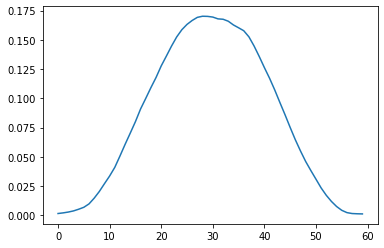

In [42]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [37]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), out_sz=360, layers=[500,200], ps=[0.5,0.5], bn_final=True, 
                         feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + add_seed)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(anum)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [38]:
VERSION = 36

In [42]:
preds = []
for fold in range(3):
    preds2 = []
    for anum in range(8):
        predictions = inference_one(fold = fold, anum = anum)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)

completed epochs: 17
loading model model.b17.f0.v36
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation 0
test processing time: 4.716512441635132
completed epochs: 17
loading model model.b17.f0.v36
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation 1
test processing time: 4.641012907028198
completed epochs: 17
loading model model.b17.f0.v36
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation 2
test processing time: 4.021617650985718
completed epochs: 17
loading model model.b17.f0.v36
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation 3
test processing time: 4.19426155090332
completed epochs: 17
loading model model.b17.f0.v36
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmen

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [44]:
predictions.mean(0)

array([0.12515758, 0.00611261, 0.04398553, 0.03232377, 0.04397949,
       0.05341499], dtype=float32)

In [65]:
predictions.mean(0)

array([0.1264937 , 0.00635758, 0.04458478, 0.03210059, 0.0448006 ,
       0.05447438], dtype=float32)

In [90]:
predictions.mean(0)

array([0.12421313, 0.00613318, 0.04336379, 0.03132349, 0.04353321,
       0.05299766], dtype=float32)

In [45]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [46]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12515757977962494

In [92]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12421312928199768

In [47]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [85]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [48]:
sub.to_csv(PATH/'sub.csv', index=False)

In [49]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9878769168485573

In [50]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f ~/sub.csv -m "TPU, densenet169, 4aug, 8TTA, 3folds, pre-sigmoid"

100%|██████████████████████████████████████| 16.6M/16.6M [00:05<00:00, 3.16MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection